<a href="https://colab.research.google.com/github/Hyper-Bits-Computer-Vision/EN3160_Improved_SLRT/blob/main/Sign_Language_Recognition_and_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sign Language Recognition and Translation**
---
# Team HyperBits
## EN-3160 Fundermentals of Image Processing and Machine Vision
## Feasibility Presentation
## Date: 2024.09.13
---

### **M.M.H.H.B. Gallella - 210174X**

### **H.M.S.I. Herath - 210218M**

# Common architectures for self-supervised learning involving Sign Language Retrieval tasks

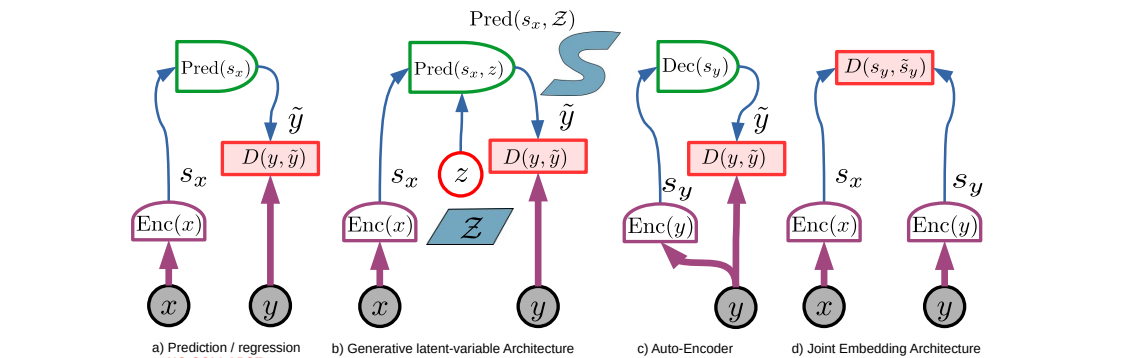

# **Content:**

###**1] Continuous Sign Language Translation Predictive architectures (type a) ;**

1. [ICCV 2021] Visual Alignment Constraint for Continuous Sign Language Recognition [Paper](https://arxiv.org/abs/2104.02330) | [Code](https://github.com/Blueprintf/VAC_CSLR)

2. [CVPR 2023] Continuous Sign Language Recognition with Correlation Network [Paper](https://arxiv.org/abs/2303.03202) | [Code](https://github.com/hulianyuyy/CorrNet)

3. [CVPR 2024] CorrNet+: Sign Language Recognition and
Translation via Spatial-Temporal Correlation [Paper](https://arxiv.org/pdf/2404.11111) | [Code](https://github.com/hulianyuyy/CorrNet_Plus)

###**2] Sign Language Retrieval via Joint Embedding Architectures (type d) ;**

1. [CVPR 2022] A Simple Multi-Modality Transfer Learning Baseline for Sign Language Translation [Paper](https://arxiv.org/abs/2203.04287) | [Code](https://github.com/FangyunWei/SLRT/tree/main/TwoStreamNetwork)

2. [NeurIPS 2022] Two-Stream Network for Sign Language Recognition and Translation [Paper](https://arxiv.org/abs/2211.01367) | [Code](https://github.com/FangyunWei/SLRT/tree/main/TwoStreamNetwork)

3. <font color='red'>[CVPR 2023] CiCo: Domain-Aware Sign Language Retrieval via Cross-Lingual Contrastive Learning</font>  [Paper](https://arxiv.org/abs/2303.12793) | [Code](https://github.com/FangyunWei/SLRT/tree/main/CiCo)

4. [CVPR 2023] Natural Language-Assisted Sign Language Recognition [Paper](https://arxiv.org/abs/2303.12080) | [Code](https://github.com/FangyunWei/SLRT/tree/main/NLA-SLR)

5. [ECCV 2024] A Simple Baseline for Spoken Language to Sign Language Translation with 3D Avatars [Paper](https://arxiv.org/abs/2401.04730) | [Code](https://github.com/FangyunWei/SLRT/tree/main/Spoken2Sign)

# **1] Continuous Sign Language Translation Predictive architectures (type a);**

# 1.1 [ICCV 2021] Visual Alignment Constraint for Continuous Sign Language Recognition [Paper](https://arxiv.org/abs/2104.02330) | [Code](https://github.com/Blueprintf/VAC_CSLR)




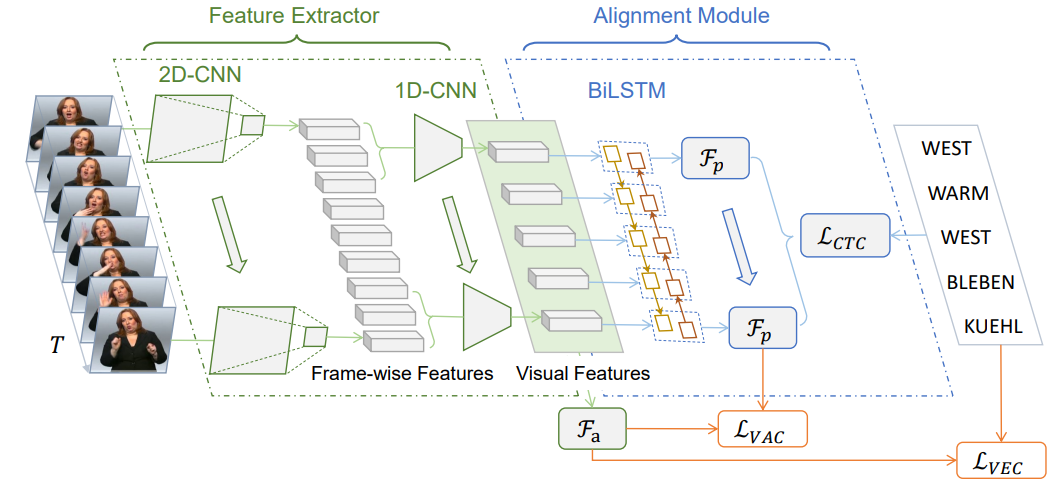

This paper focuses on addressing overfitting in vision-based Continuous Sign Language Recognition (CSLR) systems. It introducese **Visual Alignment Constraint(VAC)** implemented by **two** losses, to enhance the feature extractor by aligning visual and contextual features.VAC enhances the feature extractor, ensuring that it makes predictions based on visual features rather than totally relying on alignment module.

- **VE Loss** - This loss enforces the feature extractor to make predictions based on local visual information only.

    $$
    L_{VE} = L_{v}^{CTC} = -\log p(l|X; \theta_v)
    $$
    

- **VA Loss** - VE Loss lacks contextual information, VA Loss introduced to mitigate the potential misalignment between two classifiers

  $$
  L_{VA} = KL \left( \text{softmax}\left( \frac{Z}{\tau} \right), \text{softmax}\left( \frac{\tilde{Z}}{\tau} \right) \right).
  $$

The final objective function is,

  $$
  L = L_{CTC} + L_{VE} + \alpha L_{VA}.
  $$

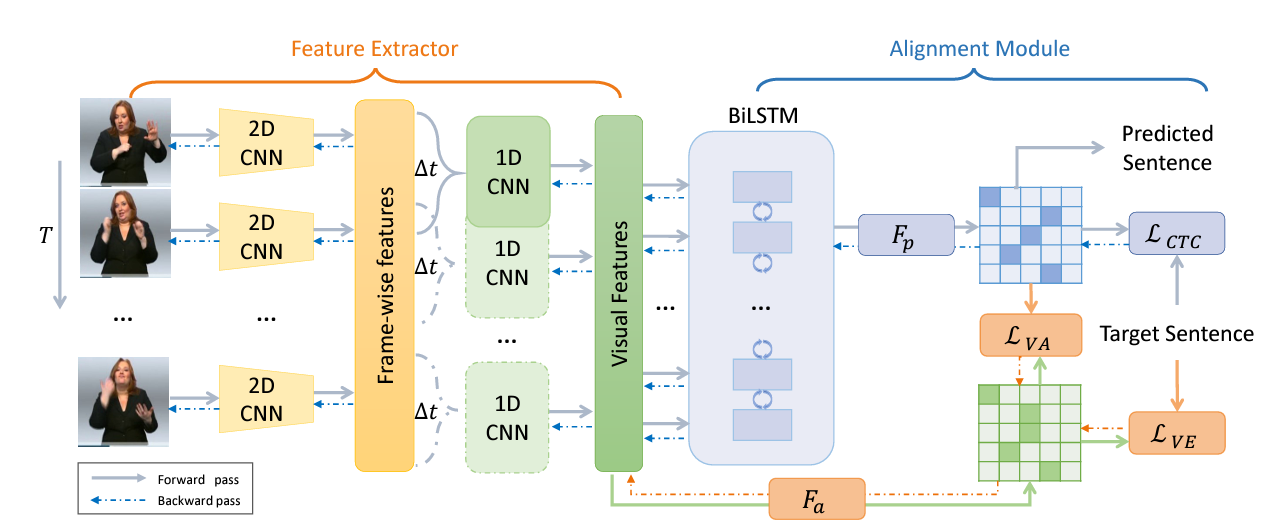

In [ ]:
class SLRModel(nn.Module):
    def __init__(self, num_classes, c2d_type, conv_type, use_bn=False,hidden_size=1024, gloss_dict=None, loss_weights=None,weight_norm=True, share_classifier=True):
        super(SLRModel, self).__init__()
        self.decoder = None
        self.loss = dict()
        self.criterion_init()
        self.num_classes = num_classes
        self.loss_weights = loss_weights
        self.conv2d = getattr(models, c2d_type)(pretrained=True)
        self.conv2d.fc = Identity()
        self.conv1d = TemporalConv(input_size=512,hidden_size=hidden_size,conv_type=conv_type,use_bn=use_bn,num_classes=num_classes)
        self.decoder = utils.Decode(gloss_dict, num_classes, 'beam')
        self.temporal_model = BiLSTMLayer(rnn_type='LSTM', input_size=hidden_size, hidden_size=hidden_size,num_layers=2, bidirectional=True)
        if weight_norm:
            self.classifier = NormLinear(hidden_size, self.num_classes)
            self.conv1d.fc = NormLinear(hidden_size, self.num_classes)
        else:
            self.classifier = nn.Linear(hidden_size, self.num_classes)
            self.conv1d.fc = nn.Linear(hidden_size, self.num_classes)
        if share_classifier:
            self.conv1d.fc = self.classifier
        self.register_backward_hook(self.backward_hook)

    def backward_hook(self, module, grad_input, grad_output):
        ..

    def masked_bn(self, inputs, len_x):
        ..

    def forward(self, x, len_x, label=None, label_lgt=None):
        if len(x.shape) == 5:
            # videos
            batch, temp, channel, height, width = x.shape
            inputs = x.reshape(batch * temp, channel, height, width)
            framewise = self.masked_bn(inputs, len_x)
            framewise = framewise.reshape(batch, temp, -1).transpose(1, 2)
        else:
            # frame-wise features
            framewise = x

        conv1d_outputs = self.conv1d(framewise, len_x)
        # x: T, B, C
        x = conv1d_outputs['visual_feat']
        lgt = conv1d_outputs['feat_len']
        tm_outputs = self.temporal_model(x, lgt)
        outputs = self.classifier(tm_outputs['predictions'])
        pred = None if self.training \
            else self.decoder.decode(outputs, lgt, batch_first=False, probs=False)
        conv_pred = None if self.training \
            else self.decoder.decode(conv1d_outputs['conv_logits'], lgt, batch_first=False, probs=False)

        return {
            "framewise_features": framewise,
            "visual_features": x,
            "feat_len": lgt,
            "conv_logits": conv1d_outputs['conv_logits'],
            "sequence_logits": outputs,
            "conv_sents": conv_pred,
            "recognized_sents": pred,
        }

    def criterion_calculation(self, ret_dict, label, label_lgt):
        loss = 0
        for k, weight in self.loss_weights.items():
            if k == 'ConvCTC':
                loss += weight * self.loss['CTCLoss'](ret_dict["conv_logits"].log_softmax(-1),
                                                      label.cpu().int(), ret_dict["feat_len"].cpu().int(),
                                                      label_lgt.cpu().int()).mean()
            elif k == 'SeqCTC':
                loss += weight * self.loss['CTCLoss'](ret_dict["sequence_logits"].log_softmax(-1),
                                                      label.cpu().int(), ret_dict["feat_len"].cpu().int(),
                                                      label_lgt.cpu().int()).mean()
            elif k == 'Dist':
                loss += weight * self.loss['distillation'](ret_dict["conv_logits"],
                                                           ret_dict["sequence_logits"].detach(),
                                                           use_blank=False)
        return loss

    def criterion_init(self):
        self.loss['CTCLoss'] = torch.nn.CTCLoss(reduction='none', zero_infinity=False)
        self.loss['distillation'] = SeqKD(T=8)
        return self.loss

# 1.2 [CVPR 2023] Continuous Sign Language Recognition with Correlation Network  [Paper](https://arxiv.org/abs/2303.03202) | [Code](https://github.com/hulianyuyy/CorrNet)

This CorrNet paper introduces a novel approach to CSLR by identifying body trajectories across video frames.

**Correlation Network (CorrNet)**: The paper proposes the CorrNet architecture, which includes:
   - [**Correlation Module**](https://github.com/hulianyuyy/CorrNet/blob/main/modules/resnet.py): Calculates correlation maps between a current frame and its adjacent frames to track trajectories. Aims to dynamically identify significant movements across frames.

In [ ]:
class Get_Correlation(nn.Module):
    def __init__(self, channels):
      ...

   - [**Identification Module**](https://github.com/hulianyuyy/CorrNet/blob/main/modules/tconv.py) Emphasizes the trajectories within the correlation maps, focusing on areas likely to represent meaningful sign language movements.

In [ ]:
class MultiScale_TemporalConv(nn.Module):
        ...

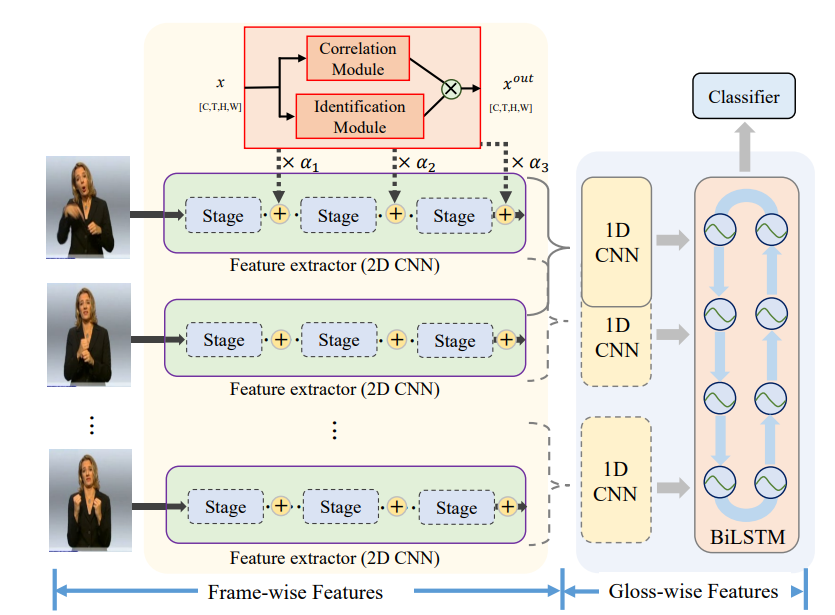



**Methodology**: The network first extracts frame-wise features using a 2D CNN. It then employs 1D CNN and BiLSTM layers for temporal modeling, with the Correlation and Identification modules applied at each stage to enhance the understanding of body movements.



**Temporal Correlation of Body Movements**
The core innovation in the CorrNet model is its ability to capture and utilize the temporal correlations between consecutive frames. This is essential for sign language recognition, where the meaning of signs can depend significantly on the movement dynamics and transitions between different signs.

- **Correlation Module**: This module computes correlation maps between the feature maps of consecutive frames. By doing this, the network can effectively track the movements of the signer's hands and other relevant body parts across frames.
- **Dynamic Tracking**: The tracking is done without any fixed keypoints, allowing the network to adaptively focus on important features relevant to the sign language context.




Visualization of correlation maps with Grad-CAM

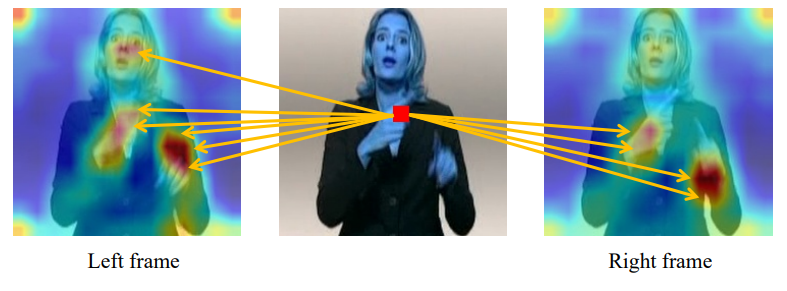

It’s observed that without extra supervision, our method could well
attend to informative regions in adjacent left/right frames to identify human body trajectories.

**Spatial-Temporal Feature Integration**
- **Spatial Analysis**: Initially, each video frame is processed through a 2D convolutional neural network (CNN) to extract spatial features, which capture the detailed visual information at each time step.

- **Temporal Modeling**: After extracting spatial features, the model uses 1D convolutional and BiLSTM layers. This combination helps in modeling temporal dependencies, allowing the network to understand sequences of movements over time.

**Enhanced Focus on Relevant Features**
By calculating correlation maps and integrating them with the main feature stream, the model ensures that attention is paid to those parts of the frame where significant motion occurs between frames.

- **Identification Module**: Post-correlation mapping, this module processes the correlation outputs to enhance and isolate regions of high relevance, essentially providing a focus mechanism that directs the network's attention to critical motion areas without external inputs like hand detectors.


**Datasets**:  PHOENIX14, PHOENIX14-T, CSL-Daily, and CSL.

# 1.3 CorrNet+: Sign Language Recognition and Translation via Spatial-Temporal Correlation [Paper](https://arxiv.org/pdf/2404.11111) | [Code](https://github.com/hulianyuyy/CorrNet_Plus)

This Corrnet+ is an improvement of CorrNet which introduces some novelties.
- **Temporal Attention Module** - Other that correlation and identification modules used in corrnet they have introduced a temporal attention module which helps in identifying and weighting critical frames.

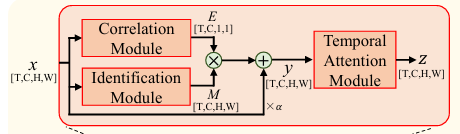

Temporal weights are calculated as such in the [modules/resnet.py](https://github.com/hulianyuyy/CorrNet_Plus/blob/main/CorrNet_Plus_CSLR/modules/resnet.py) in the code

---



In [ ]:
class Temporal_weighting(nn.Module):
    def __init__(self, input_size ):
        super().__init__()
        hidden_size = input_size//16
        self.conv_transform = nn.Conv1d(input_size, hidden_size, kernel_size=1, stride=1, padding=0)
        self.conv_back = nn.Conv1d(hidden_size, input_size, kernel_size=1, stride=1, padding=0)
        #self.conv_enhance = nn.Conv1d(hidden_size, hidden_size, kernel_size=9, stride=1, padding=4)
        self.num = 3
        self.conv_enhance = nn.ModuleList([
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=int(i+1), groups=hidden_size, dilation=int(i+1)) for i in range(self.num)
        ])
        self.weights = nn.Parameter(torch.ones(self.num) / self.num, requires_grad=True)
        self.alpha = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv_transform(x.mean(-1).mean(-1))
        aggregated_out = 0
        for i in range(self.num):
            aggregated_out += self.conv_enhance[i](out) * self.weights[i]
        out = self.conv_back(aggregated_out)
        return x*(F.sigmoid(out.unsqueeze(-1).unsqueeze(-1))-0.5) * self.alpha

- **Different Approach for Applying Correlation** -  While CorrNet computes correlation maps between every spatial patch in a frame x_t and all patches in neighboring frames while CorrNet+ takes in to account the selected features of x_t. Additionally, CorrNet+ extends the temporal context by allowing correlation maps to be computed with frames further apart in time.

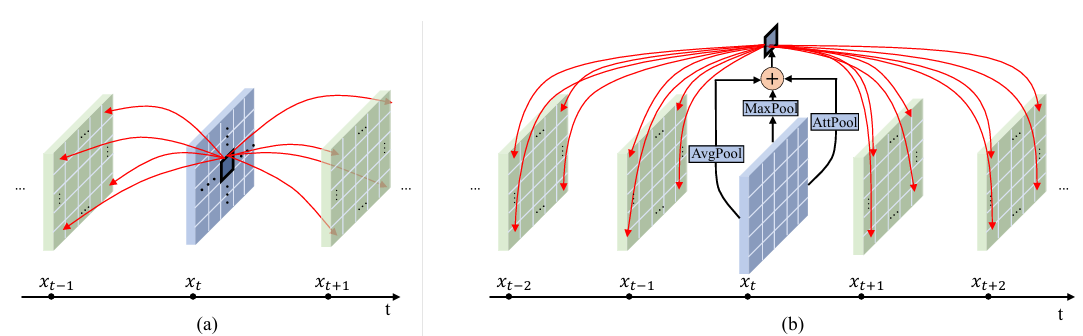

We calculate **Correlation maps** between patches in neighboring frames to model human body trajectories. The equation for the correlation is given by:

$$
A(i, j, i', j') = \frac{1}{C} \sum_{c=1}^{C} p^c_t(i, j) \times p^c_{t+1}(i', j')
$$

where:

- $A(i, j, i', j')$ is the **affinity** (correlation) between the patches at position $ (i, j) $ in frame $ x_t $ and at position $ (i', j') $ in frame $ x_{t+1} $,
- $C$ is the **number of channels**,
- $p^c_t(i, j)$ represents the **value** of the patch at position $ (i, j) $ in frame $x_t$ for channel $ c $,
- $p^c_{t+1}(i', j')$ represents the **value** of the patch at position $ (i', j') $ in frame $ x_{t+1} $ for channel $ c $.


In the paper, they calculate **correlation maps** between patches in neighboring frames to model human body trajectories. The equation for the correlation is given by:

$$
A(i, j, i', j') = \frac{1}{C} \sum_{c=1}^{C} p^c_t(i, j) \times p^c_{t+1}(i', j')
$$

where:

- $A(i, j, i', j')$ is the **affinity** (correlation) between the patches at position $ (i, j) $ in frame $ x_t $ and at position $ (i', j') $ in frame $ x_{t+1} $,
- $C$ is the **number of channels**,
- $p^c_t(i, j)$ represents the **value** of the patch at position $ (i, j) $ in frame $x_t$ for channel $ c $,
- $p^c_{t+1}(i', j')$ represents the **value** of the patch at position $ (i', j') $ in frame $ x_{t+1} $ for channel $ c $.


# **2] Sign Language Retrieval via Joint Embedding Architectures (type d);**

# 2.1 [CVPR 2022 - TwoStreamNetwork] A Simple Multi-Modality Transfer Learning Baseline for Sign Language Translation [Paper](https://arxiv.org/abs/2203.04287) | [Code](https://github.com/FangyunWei/SLRT/tree/main/TwoStreamNetwork)

Sign language translation (SLT) and Sign Language Recognition (SLR) is a challenging task due to the scarcity of large parallel datasets compared to spoken language translation. To address this, the research paper proposes a multi-modal transfer learning model that leverages general-domain pretraining and within-domain fine-tuning to improve translation accuracy, and finally conducting multi-modal joint training. By decoupling the translation process into visual (Sign2Gloss) and language (Gloss2Text) tasks, the model achieves state-of-the-art performance on sign language benchmarks. Below is a detailed explanation of the architecture, including key equations and functions.

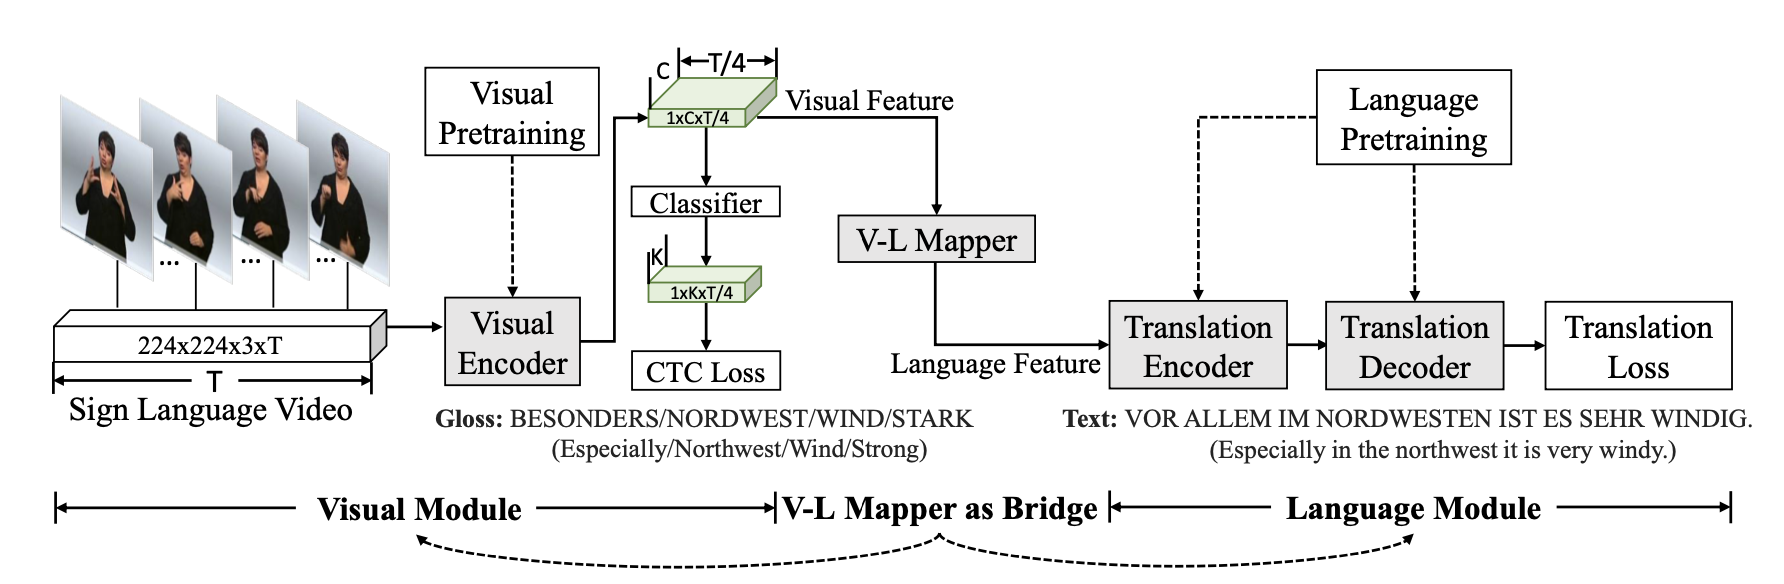

### Model Architecture
The model for **Sign Language Translation** is broken into two main components:
1. **Sign-to-Gloss (Sign2Gloss)** – This part of the model takes sign language videos and outputs gloss sequences, a word-for-word transcription of signs.
2. **Gloss-to-Text (Gloss2Text)** – This second stage takes the glosses and translates them into spoken language text.

To bridge these two tasks, the authors introduce a **Visual-Language Mapper (V-L Mapper)**, which connects the features extracted from the sign videos with the language translation task.

### Key Components:
1. **Visual Encoder**: The **S3D** network ( *Separable 3D Convolutional Network:"3D" refers to the fact that the model applies convolutions across both spatial dimensions (height and width) and the temporal dimension (time), which makes it suitable for understanding videos*) is used to process sign language videos. The input is a video, and the output is a temporal sequence of visual features. This part is crucial for **Sign2Gloss**.
    - The network is first pretrained on general human action recognition tasks (e.g., **Kinetics-400** and **WLASL**), and then fine-tuned for sign language translation with gloss annotations.
    - **Equation 1**: Given a video input $ V = (v_1, v_2, \dots, v_T) $, the visual encoder outputs a sequence of features $ F = E(V) $.

2. **Gloss Prediction**: The glosses are predicted from the features using a **Connectionist Temporal Classification (CTC)** loss function. The CTC loss allows the model to handle the alignment of gloss sequences with the video frames.
    - **Equation 2**: The probability of the gloss sequence $ G $ given the video $ V $ is modeled as:
      $$
      P(G|V) = \sum_{\pi \in B} P(\pi|V)
      $$
      where $ \pi $ represents all possible alignments of the gloss sequence with the video frames.

3. **Gloss-to-Text Translation (Gloss2Text)**: This module is a **sequence-to-sequence Transformer** initialized with the **mBART** model (a multilingual denoising autoencoder). The transformer translates the predicted gloss sequence into spoken language text. The input glosses are tokenized and processed into embeddings, which are passed through the transformer.
    - **Equation 3**: The translation model learns to predict the text sequence $ T = (t_1, t_2, \dots, t_U) $ given the gloss sequence $ G $:

  $$
  P(T|G) = D(G)
  $$  
  where $ D $ is the decoder in the transformer architecture.

4. **Visual-Language Mapper (V-L Mapper)**: This module bridges the visual encoder and the translation network. It takes the gloss representations (before classification) and maps them into language embeddings for joint training of both the visual and language modules. It is implemented as a simple MLP (multilayer perceptron).

### Training Process:
1. **Progressive Pretraining**: The model is first pretrained on general datasets (e.g., human action recognition and spoken language translation) and then fine-tuned on sign language-specific tasks. This helps the model learn general features that can be transferred to sign language translation, which suffers from limited data availability.
2. **Joint Training**: After pretraining, both the **visual encoder** and **language network** are fine-tuned jointly using the **CTC loss** and **cross-entropy loss**.

The architecture achieves state-of-the-art performance on sign language translation benchmarks like PHOENIX-2014T and CSL-Daily.

# 2.2 [NeurIPS 2022] Two-Stream Network for Sign Language Recognition and Translation [Paper](https://arxiv.org/abs/2211.01367) | [Code](https://github.com/FangyunWei/SLRT/tree/main/TwoStreamNetwork)

This research paper presents a novel framework called TwoStream-SLR, designed to enhance sign language recognition (SLR) and sign language translation (SLT) by effectively modeling both RGB videos and keypoint sequences. The model introduces a dual visual encoder architecture that processes visual signals through two parallel streams, integrating them using techniques like bidirectional lateral connection, sign pyramid networks, and frame-level self-distillation. These innovations address challenges like data scarcity and visual redundancy, leading to state-of-the-art performance across several benchmark datasets, including Phoenix-2014 and CSL-Daily. The proposed TwoStream-SLR model is further extended to TwoStream-SLT by attaching a translation network, enabling robust and accurate translation of sign language videos into spoken language text.

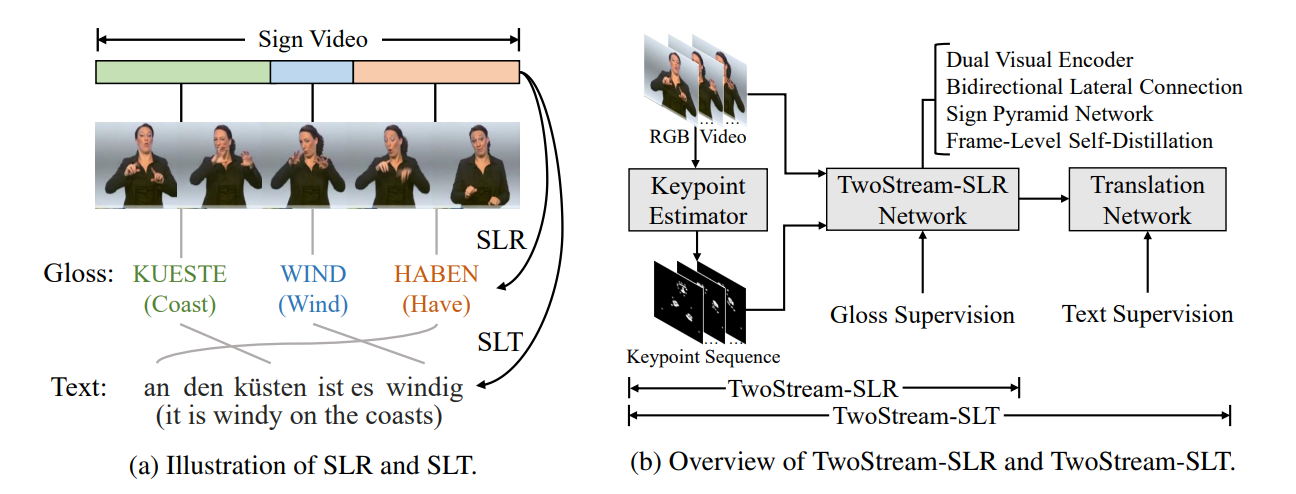




- **Figure 1a** illustrates the relationship between Sign Language Recognition (SLR) and Sign Language Translation (SLT). SLR aims to recognize a sequence of glosses from a sign video, while SLT translates sign videos directly into spoken language text.
- **Figure 1b** provides an overview of the TwoStream-SLR and TwoStream-SLT architectures. The TwoStream-SLR model consists of a dual visual encoder that processes RGB videos and keypoint sequences. The outputs from these encoders are fused using various techniques such as bidirectional lateral connection and frame-level self-distillation.

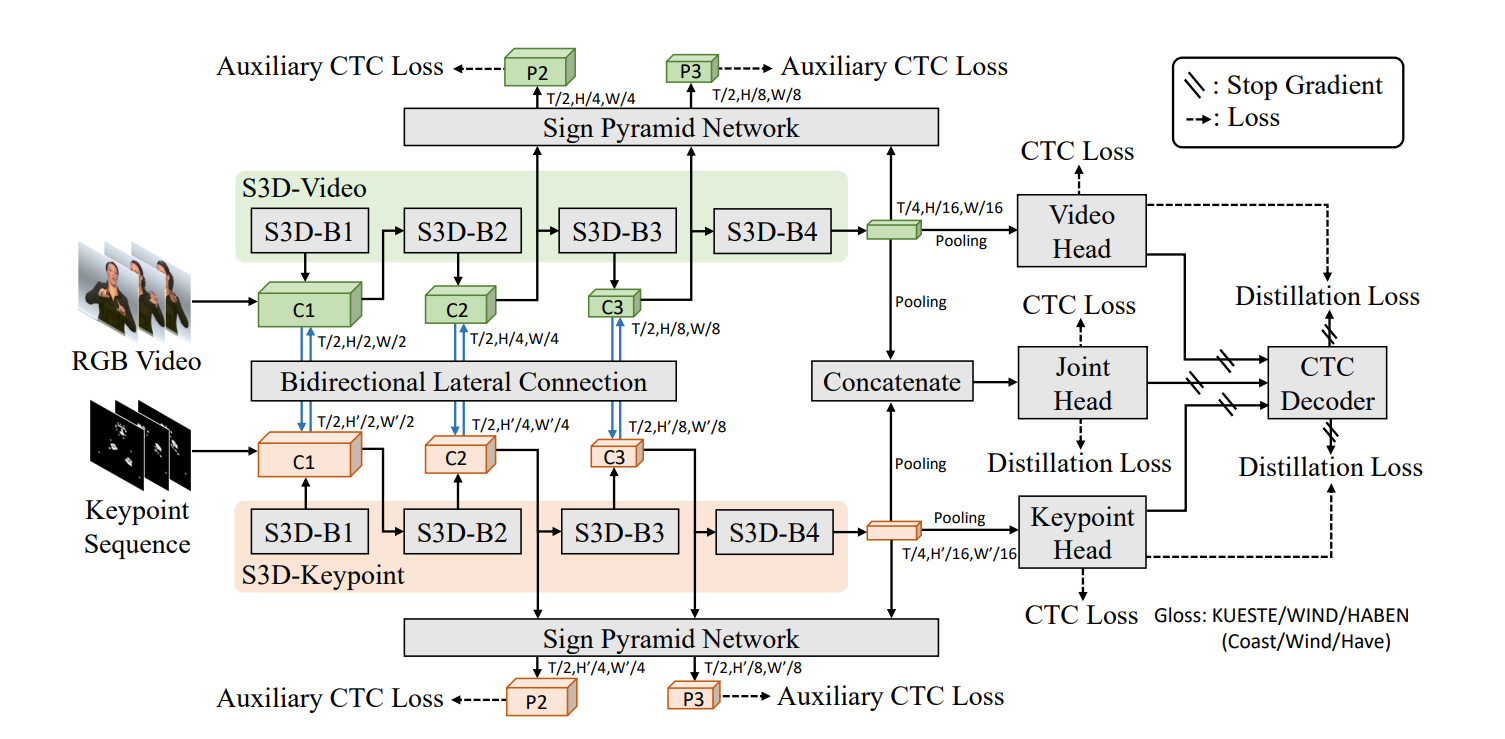

- This figure provides a detailed schematic of the TwoStream-SLR model. It includes the video encoder and keypoint sequence encoder, bidirectional lateral connection, sign pyramid networks, and the joint head. This figure also indicates where the different losses (CTC loss and self-distillation loss) are applied.

**Key Components:**
1. **Dual Visual Encoder:** Two separate S3D backbones encode the RGB videos and keypoint sequences, which are then processed to predict gloss sequences.
   - *Equation 1* describes the overall loss function for TwoStream-SLR, which includes CTC losses for the video and keypoint streams as well as auxiliary losses from the sign pyramid network.
   
   **Equation 1:**
  $$
   L_{SLR} = L_{V_{CTC}} + L_{K_{CTC}} + L_{J_{CTC}} + \lambda_V L_{V_{ACTC}} + \lambda_K L_{K_{ACTC}} + L_{Dist}
  $$

2. **Bidirectional Lateral Connection:** This allows information exchange between the video and keypoint streams to address inaccuracies in keypoint estimation and redundancy in video frames.
   
3. **Sign Pyramid Network (SPN):** SPN is used to capture glosses of varying temporal spans and enhance feature learning in intermediate layers.

4. **Frame-Level Self-Distillation:** This involves using the averaged gloss probabilities as pseudo-targets for frame-level supervision, improving the model's learning capabilities.

Equation 1 code:

In [ ]:
import torch
import torch.nn.functional as F

# CTC Losses for video, keypoint, and joint streams
L_V_CTC = ctc_loss(video_predictions, targets, video_lengths, target_lengths)
L_K_CTC = ctc_loss(keypoint_predictions, targets, keypoint_lengths, target_lengths)
L_J_CTC = ctc_loss(joint_predictions, targets, joint_lengths, target_lengths)

# Auxiliary CTC Losses from the Sign Pyramid Networks
L_V_ACTC = ctc_loss(video_spn_predictions, targets, video_lengths, target_lengths)
L_K_ACTC = ctc_loss(keypoint_spn_predictions, targets, keypoint_lengths, target_lengths)

# Frame-Level Self-Distillation Loss
L_Dist = distillation_loss(pseudo_targets, [video_predictions, keypoint_predictions, joint_predictions])

# Combine all losses with their respective weights
λ_V = 0.2
λ_K = 0.5

L_SLR = L_V_CTC + L_K_CTC + L_J_CTC + λ_V * L_V_ACTC + λ_K * L_K_ACTC + L_Dist


This code defines the overall loss function for the TwoStream-SLR model, which includes contributions from multiple CTC losses, auxiliary losses, and the distillation loss.

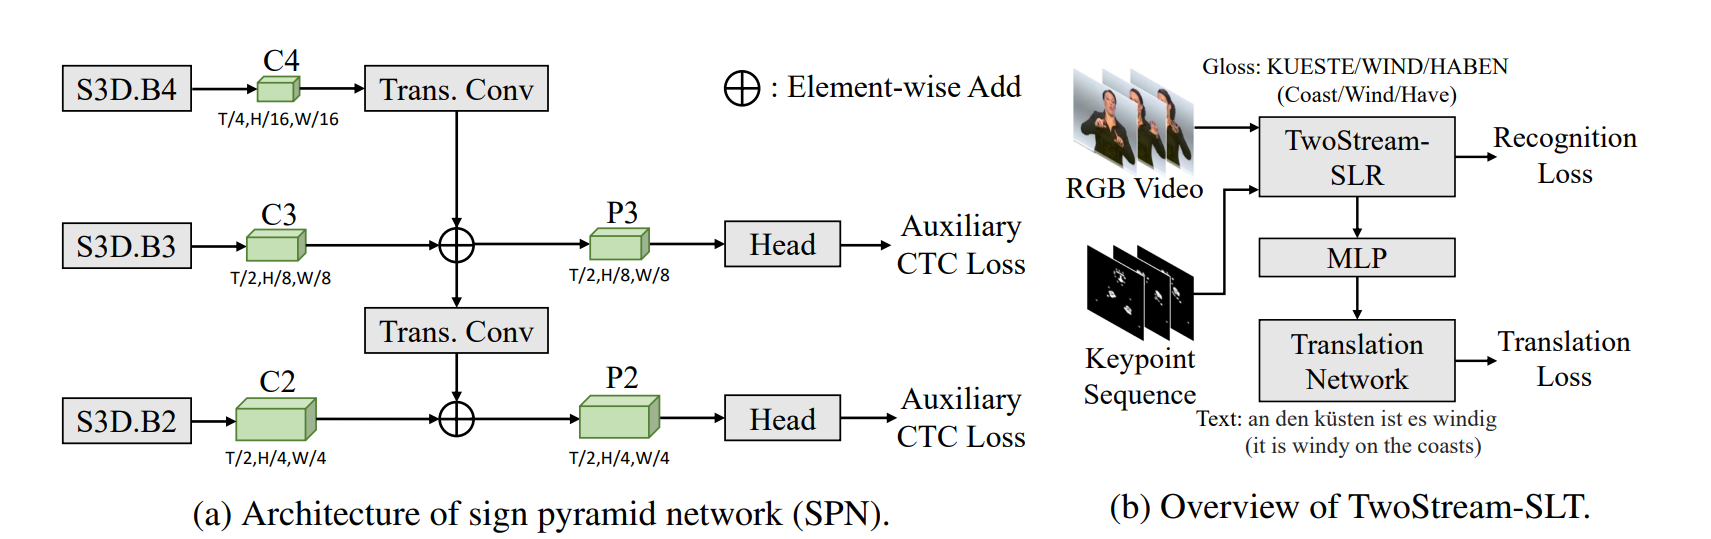

- This explains the architecture of the sign pyramid network, detailing how it takes features from different S3D blocks and processes them using transposed convolution and element-wise addition.
- **Figure 3b** illustrates the extension of TwoStream-SLR to TwoStream-SLT, where a translation network is added to predict the spoken language text from the gloss sequences.

### Code Blocks and Equations:
- **CTC Loss (Equation 4):** The CTC loss is used extensively across the model for supervising the prediction of gloss sequences from both the video and keypoint streams.
  
  **Equation 4:**
  $$
  L_{CTC} = - \ln p(G|V)
  $$



In [ ]:
import torch.nn.functional as F

def ctc_loss(predictions, targets, input_lengths, target_lengths):
    return F.ctc_loss(predictions, targets, input_lengths, target_lengths, blank=0, reduction='mean')


- **Self-Distillation Loss (Equation 6):** This loss is used to distill knowledge back into each stream by minimizing the KL-divergence between the pseudo-targets and individual stream predictions.
  
  **Equation 6:**
  $$
  L_{Dist} = \sum_{i=1}^{T/4} \left( D(p_{a_i} \parallel p_{v_i}) + D(p_{a_i} \parallel p_{k_i}) + D(p_{a_i} \parallel p_{j_i}) \right)
  $$



In [ ]:
import torch

def kl_divergence(p, q):
    return F.kl_div(q.log(), p, reduction='batchmean')

def distillation_loss(pseudo_targets, predictions_list):
    loss =  0.0
    for predictions in predictions_list:
        loss += kl_divergence(pseudo_targets, predictions)
    return loss


- **Translation Loss (Equation 7):** This is a standard sequence-to-sequence cross-entropy loss applied to the translation network.
  
  **Equation 7:**
  $$
  L_{T} = - \ln p(S|V) = - \sum_{i=1}^{W} \ln p(s_i|s_{<i}, V)
  $$

In [ ]:
def translation_loss(translation_predictions, target_sequence):
    # target_sequence is the ground truth sequence of tokens
    # translation_predictions is the predicted sequence of tokens
    return F.cross_entropy(translation_predictions.view(-1, translation_predictions.size(-1)), target_sequence.view(-1), ignore_index=padding_idx)


# 2.3 [CVPR 2023] CiCo: Domain-Aware Sign Language Retrieval via Cross-Lingual Contrastive Learning [Paper](https://arxiv.org/abs/2303.12793) | [Code](https://github.com/FangyunWei/SLRT/tree/main/CiCo)

This paper introduce a novel architecture for Cross-Lingual mapping with contrastive learning

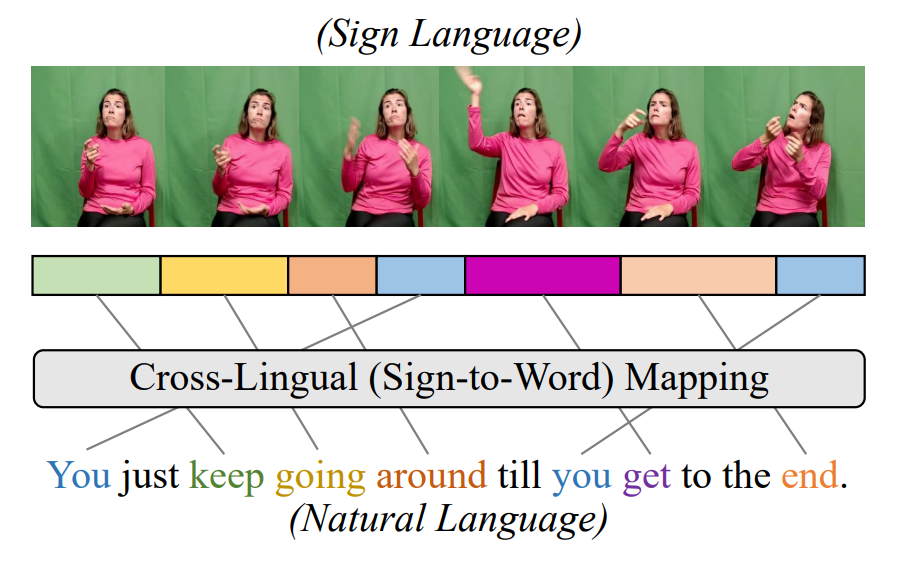


### 1. **CiCo Framework Overview**
The CiCo framework is designed for sign language retrieval, tackling two tasks:
- **Text-to-Sign-Video Retrieval (T2V)**: Find the sign video that best matches a text query.
- **Sign-Video-to-Text Retrieval (V2T)**: Identify the most relevant text description for a given sign video.

#### Architecture Components:
- **Sign Encoder**:
  - **Domain-Agnostic Sign Encoder** (`hξ(v)`): Pre-trained on a large-scale dataset (e.g., BSL-1K) to extract features from sign videos.
  - **Domain-Aware Sign Encoder** (`hθ(v)`): Fine-tuned on the target domain using pseudo-labeled data to adapt to specific datasets.
  - **Final Sign Encoder**: Combines the outputs of both the domain-agnostic and domain-aware encoders, weighted by a hyper-parameter `α`.

- **Cross-Lingual Contrastive Learning (CLCL)**:
  - Aligns sign video features and text features in a joint embedding space.
  - Identifies fine-grained sign-to-word mappings through the similarity between sign clips and words.

### 2. **Key Equations**
- **Feature Extraction Equation**:
  $$
  H(v) = \alpha hξ(v) + (1− \alpha) hθ(v)
  $$
  This equation represents the weighted combination of the domain-agnostic and domain-aware sign encoders.

  ```
  -$cd I3D_feature_extractor
-$python get_features.py
  ```

In [ ]:
CiCo/I3D_feature_extractor/get_features.py > extract_sign_features.py > epoch.py

In [ ]:
    plog.info("\nEvaluation only")
    loss, acc = do_epoch(
        args.split,
        val_loader,
        model,
        criterion,
        num_classes=args.num_classes,
        debug=args.debug,
        checkpoint=args.checkpoint,
        mean=val_mean,
        std=val_std,
        feature_dim=args.feature_dim,
        save_logits=True,
        save_features=args.save_features,
        num_figs=args.num_figs,
        topk=args.topk,
        save_dir=os.path.join(save_dir,args.split),
        epochno=args.rank,
    )

To Train CLCL
```
-$cd CLCL
-$python -m torch.distributed.launch --nproc_per_node=4 main_task_retrieval.py --do_train
```


- **Cross-Lingual Similarity Matrix**:
  $$
  E(i,j) = S_i \cdot W_j^T
  $$
  where $S_i$ represents sign features of video $v_i$ and $W_j$ represents word features of text $t_j$.




```
CiCo/CLCL/main_task_retrieval.py
```

- **Loss Function**:
  - **Video-to-Text Contrastive Loss**:
  $$
    L_{V2T} = -\frac{1}{2N} \sum_{i=1}^{N} \log \frac{\exp(Z_{V2T}^{(i,j)}/\tau)}{\sum_{j=1}^{N} \exp(Z_{V2T}^{(i,j)}/\tau)} - \frac{1}{2N} \sum_{j=1}^{N} \log \frac{\exp(Z_{V2T}^{(i,j)}/\tau)}{\sum_{i=1}^{N} \exp(Z_{V2T}^{(i,j)}/\tau)}
  $$
  where $\tau$ is the trainable parameter

  ```
CiCo/CLCL/modules/until_module.py
  ```

  - **Total Loss**:
  $$
    L = \beta L_{V2T} + (1− \beta) L_{T2V}
  $$
    where β is a hyper-parameter.

In [ ]:
class MILNCELoss(nn.Module):
    def __init__(self, batch_size=1, n_pair=1,):
        super(MILNCELoss, self).__init__()
        self.batch_size = batch_size
        self.n_pair = n_pair
        torch_v = float(".".join(torch.__version__.split(".")[:2]))
        self.bool_dtype = torch.bool if torch_v >= 1.3 else torch.uint8

    def forward(self, sim_matrix):
        mm_mask = np.eye(self.batch_size)
        mm_mask = np.kron(mm_mask, np.ones((self.n_pair, self.n_pair)))
        mm_mask = torch.tensor(mm_mask).float().to(sim_matrix.device)

        from_text_matrix = sim_matrix + mm_mask * -1e12
        from_video_matrix = sim_matrix.transpose(1, 0)

        new_sim_matrix = torch.cat([from_video_matrix, from_text_matrix], dim=-1)
        logpt = F.log_softmax(new_sim_matrix, dim=-1)

        mm_mask_logpt = torch.cat([mm_mask, torch.zeros_like(mm_mask)], dim=-1)
        masked_logpt = logpt + (torch.ones_like(mm_mask_logpt) - mm_mask_logpt) * -1e12

        new_logpt = -torch.logsumexp(masked_logpt, dim=-1)   # Log sum exp

        logpt_choice = torch.zeros_like(new_logpt)
        mark_ind = torch.arange(self.batch_size).to(sim_matrix.device) * self.n_pair + (self.n_pair//2)
        logpt_choice[mark_ind] = 1
        sim_loss = new_logpt.masked_select(logpt_choice.to(dtype=self.bool_dtype)).mean()
        return sim_loss

## Sign Encoder

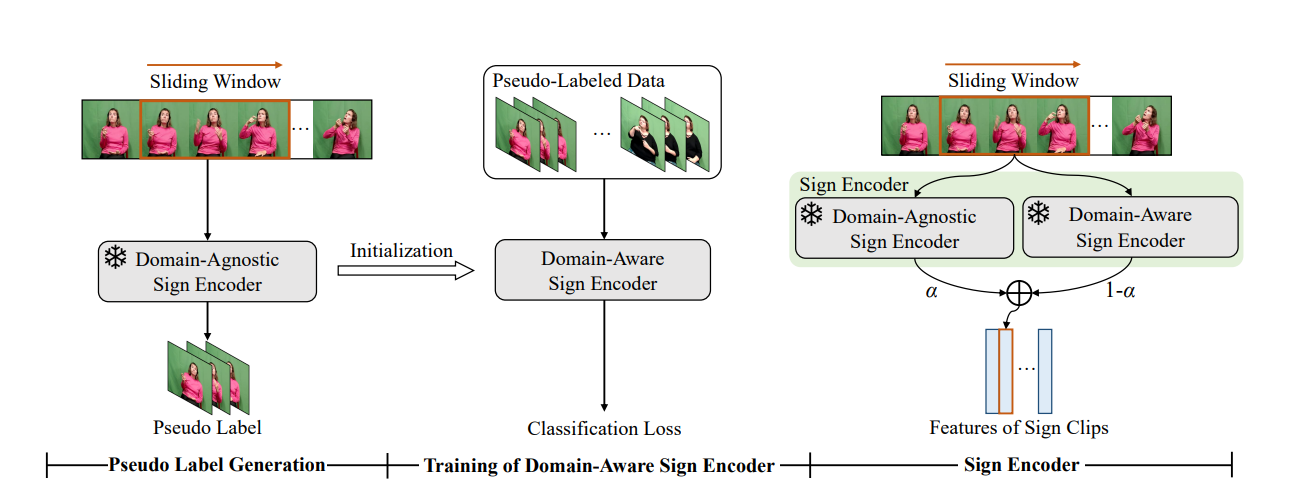

Sign encoder is composed of a domain-agnostic sign encoder and a domain-aware sign encoder. Both encoders use the same Inception-v1 I3D architecture.

I3D models trained on Kinetics [Paper](https://arxiv.org/abs/1705.07750) | [Code](https://github.com/google-deepmind/kinetics-i3d)

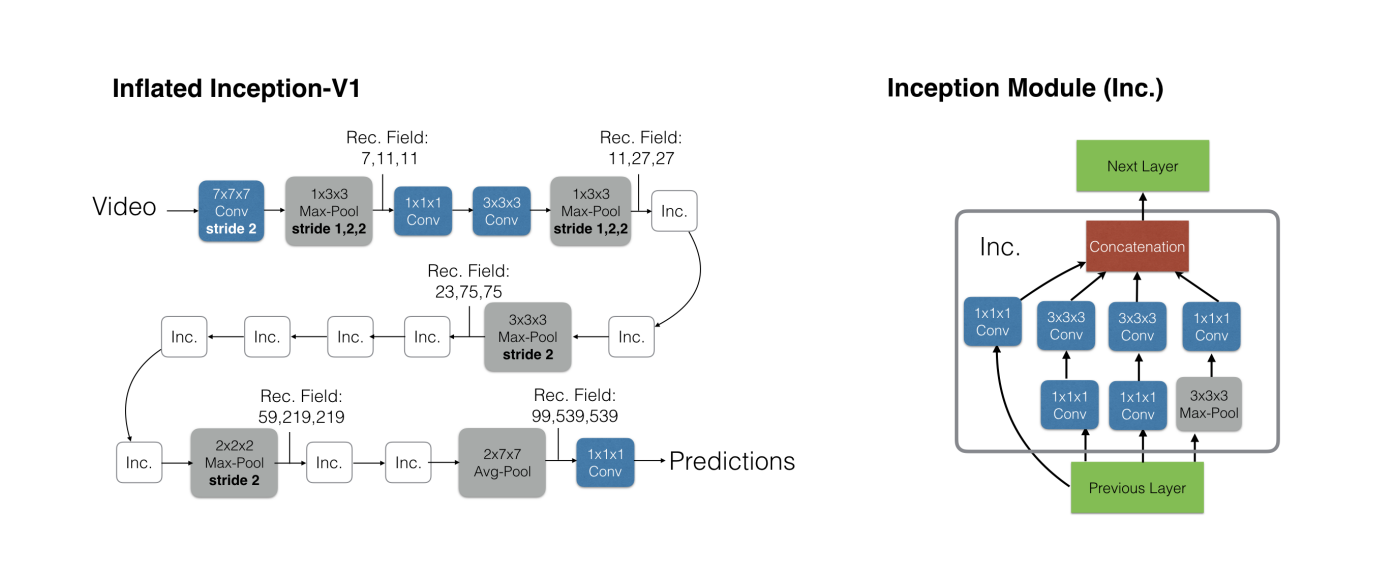

**Domain - Agnostic Sign encoder (hξ(v)):**
```
CiCo/I3D_feature_extractor/models/i3d.py
```
This is the **I3D** model trained on kinetics large scale dataset. This encoder creates a generalized representation of sign language, extracting generalized features. This allows it to generalize and work well with various datasets and domains.

\\
**Domain -Aware Sign encoder hθ(v):**
```
CiCo/I3D_feature_extractor/models/i3d.py
```
Domain-aware encoder is domain agnostic encoder trained on fine-tuned on pseudo labelled sign language data.

## CLCL: cross-lingual contrastive learning.

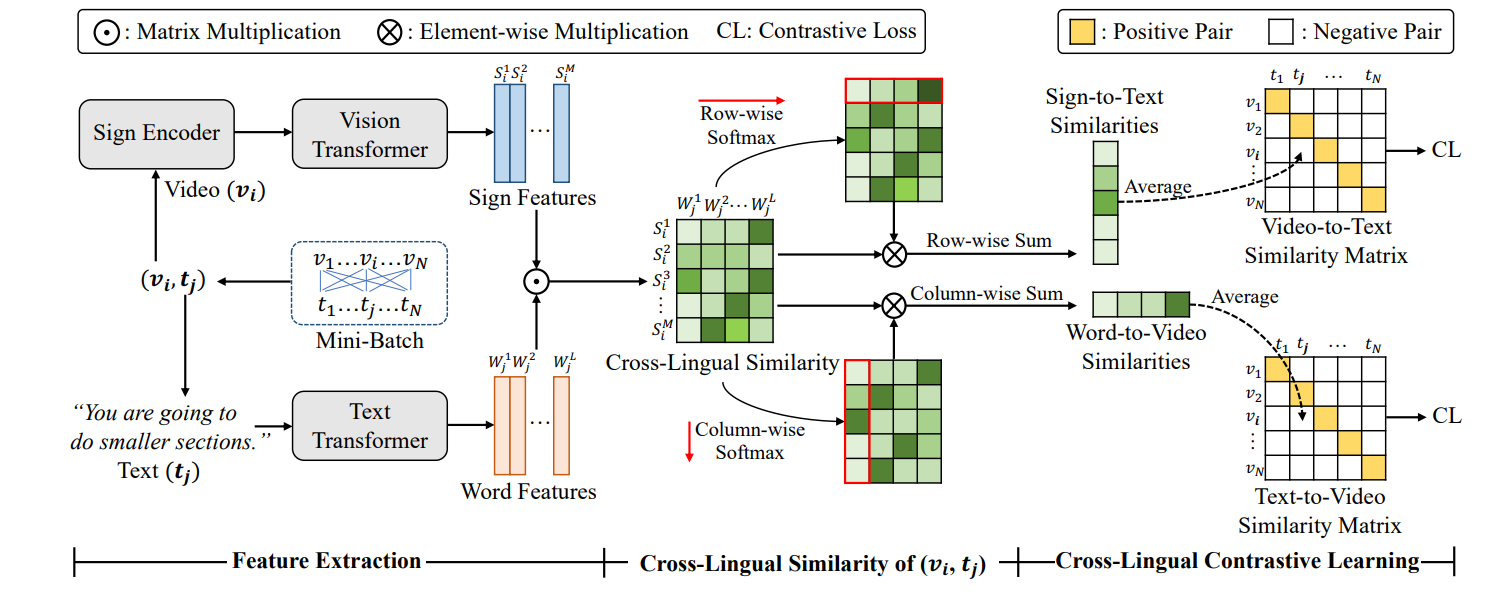

- Vision Transformer: vision encoder [CLIP](https://github.com/FangyunWei/SLRT/blob/main/CiCo/CLCL/modules/module_clip.py) (ViT-B/32)
  ```
  CiCo/CLCL/modules/module_clip.py
  ```
- Text Transformer: text encoder in [CLIP](https://github.com/FangyunWei/SLRT/blob/main/CiCo/CLCL/modules/module_clip.py)

  ```
  CiCo/CLCL/modules/module_clip.py
  ```

Trained model will saves at: Code
```
CiCo/CLCL/chpt/final_models
```

Full Code of calculating similarity matrices:
```
CiCo/CLCL/main_task_retrieval.py
```


### 3. **Pseudocode Snippet**
Here’s an abstracted pseudocode illustrating the key steps in the CiCo framework:

In [ ]:
# Pseudo-code for the CiCo framework

## Stage 1
# H(v) is the final sign encoder with domain generalization
H_v = alpha * domain_agnostic_sign_encoder(v) + (1 - alpha) * domain_aware_sign_encoder(v)


## Stage 2
# Cross-lingual similarity computation
E_ij = sign_features @ word_features.T  # Matrix multiplication for similarity

# Contrastive Loss computation
L_V2T = compute_contrastive_loss(Z_V2T)
L_T2V = compute_contrastive_loss(Z_T2V)
total_loss = beta * L_V2T + (1 - beta) * L_T2V

# Training loop
for epoch in range(num_epochs):
    # Feature extraction and loss computation
    H_v = compute_H(v)
    E_ij = compute_similarity(H_v, W_t)
    loss = compute_total_loss(E_ij)
    optimizer.step(loss)

Four Steps of CLCL training:

1. **Generation of Sign Features \( W_j \) and Word Features \( S_j \) using the Sign Encoder + CLIP Vision Encoder and CLIP Text Encoder for each video-sentence pair \( (v_i, t_i) \). Using the methods `get_sequence_visual_output`, `get_sequence_output`, and `get_visual_output` in the `CLIP4Clip` model.**

2. **Construction of the Cross-Lingual Similarity Matrix by computing the dot product between \( W_j \) and \( S_j \). Inside the `get_similarity_logits` method.**

3. Softmax operations are applied row-wise and column-wise within `get_similarity_logits` to normalize the similarity scores.

4. **The normalized similarities are averaged and concatenated to build the final Video-to-Text and Text-to-Video similarity matrices, which are then used for evaluation.**


Full Code for CLCL training:
```
CiCo/CLCL/main_task_retrieval.py
```


---

### **1. Generation of Sign Features $ S_j $ and Word Features $ W_j $**

In the code, this process is handled by the `CLIP4Clip` model, specifically through methods like `get_sequence_visual_output`, `get_sequence_output`, and `get_visual_output`. The features are generated for both the text and video inputs.


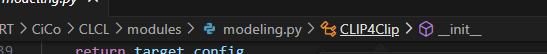


**Relevant Code:**

```python
# In the eval_epoch function:
def eval_epoch(args, model, test_dataloader, device, n_gpu, istrain):
    # ...
    model.eval()
    with torch.no_grad():
        # Lists to store outputs
        batch_sequence_output_list, batch_visual_output_list = [], []
        # ...

        # Loop over the test data
        for bid, batch in enumerate(test_dataloader):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, video, video_mask = batch

            # Get sequence and visual outputs from the model
            sequence_output, visual_output = model.get_sequence_visual_output(
                input_ids, segment_ids, input_mask, video, video_mask, shaped=True
            )

            # Append outputs to lists
            batch_sequence_output_list.append(sequence_output)
            batch_visual_output_list.append(visual_output)
            # ...
```

**Explanation:**

- **`model.get_sequence_visual_output`**: This method processes the text and video inputs to generate the respective features.
  - **Text Inputs**: `input_ids`, `segment_ids`, `input_mask` are used to generate the word features \( S_j \) using the CLIP Text Encoder.
  - **Video Inputs**: `video`, `video_mask` are used to generate the sign features \( W_j \) using the Sign Encoder and CLIP Vision Encoder.
- The outputs `sequence_output` and `visual_output` are tensors representing the features extracted from the text and video inputs, respectively.
- These outputs are then stored in lists for further processing.

---

### **2. Construction of the Cross-Lingual Similarity Matrix**

After obtaining the features \( W_j \) and \( S_j \), the code computes the similarity matrices by taking the dot product between them.

**Relevant Code:**

```python
# In the _run_on_single_gpu_new_mix function:
def _run_on_single_gpu_new_mix(model, batch_list_v, batch_list_t, batch_sequence_output_list, batch_visual_output_list, sequence_cls, visual_cls, is_train, hybird=False, alpha=0.5, dual_mix=0.5):
    with torch.no_grad():
        sim_matrix_i2t = []
        sim_matrix_t2i = []
        for idx1, b1 in enumerate(batch_list_v):
            video_mask = b1
            visual_output = batch_visual_output_list[idx1]
            # ...
            each_row = []
            each_row_t2i = []
            for idx2, b2 in enumerate(batch_list_t):
                text_mask = b2
                sequence_output = batch_sequence_output_list[idx2]
                # ...

                # Compute similarity logits
                i2t, t2i, *_tmp = model.get_similarity_logits(
                    sequence_output, visual_output, text_mask, video_mask,
                    loose_type=model.loose_type, is_train=True
                )

                # Convert logits to numpy arrays
                i2t = i2t.cpu().detach().numpy()
                t2i = t2i.cpu().detach().numpy()

                # Combine similarities
                each_row.append(i2t * dual_mix + t2i * (1 - dual_mix))
                each_row_t2i.append(i2t * dual_mix + t2i * (1 - dual_mix))
            # ...
        return sim_matrix_i2t, sim_matrix_t2i
```

**Explanation:**

- **`model.get_similarity_logits`**: This method computes the similarity scores (logits) between the text and video features.
  - It takes the sequence outputs (`sequence_output`) and visual outputs (`visual_output`) along with their masks.
  - Internally, it computes the dot product between \( W_j \) and \( S_j \), constructing the cross-lingual similarity matrix.
- The variables `i2t` and `t2i` represent the similarity scores from image-to-text and text-to-image perspectives, respectively.
- The similarity scores are then combined using a mix ratio `dual_mix`.

---

### **3. Row-wise and Column-wise Softmax and Sum Operations**

The softmax operations are applied to the similarity matrices to compute probabilities, which are then summed.

**Relevant Code:**

While the exact implementation of the softmax operations is inside the `get_similarity_logits` method (which is part of the `CLIP4Clip` model), we can infer that these operations are performed there.

```python
# Inside the model.get_similarity_logits method (not shown here)
# The method likely includes code similar to:

def get_similarity_logits(self, sequence_output, visual_output, text_mask, video_mask, loose_type=True, is_train=True):
    # Compute dot product similarity matrix
    similarity_matrix = torch.matmul(sequence_output, visual_output.transpose(-1, -2))

    # Apply masks to the similarity matrix
    # ...

    # Row-wise softmax
    similarity_row_softmax = torch.nn.functional.softmax(similarity_matrix, dim=-1)

    # Column-wise softmax
    similarity_col_softmax = torch.nn.functional.softmax(similarity_matrix, dim=-2)

    # Sum over the required dimensions
    # ...

    # Return the similarity scores
    return similarity_row_softmax, similarity_col_softmax
```

**Explanation:**

- **Row-wise Softmax**: Applied across each row to normalize the similarity scores for each text feature with respect to all video features.
- **Column-wise Softmax**: Applied across each column to normalize the similarity scores for each video feature with respect to all text features.
- The sums of these softmax probabilities are computed to aggregate the similarities.

*Note:* Since the exact implementation is inside the `CLIP4Clip` model (which isn't fully shown here), the softmax operations are assumed to be performed in the `get_similarity_logits` method.

---

### **4. Averaging the Sums and Building the Final Similarity Matrices**

After obtaining the normalized similarity scores, the code averages them to build the final Video-to-Text and Text-to-Video similarity matrices.

**Relevant Code:**

```python
# Continuing from the _run_on_single_gpu_new_mix function:

                # Combine similarities using dual_mix ratio
                each_row.append(i2t * dual_mix + t2i * (1 - dual_mix))
                each_row_t2i.append(i2t * dual_mix + t2i * (1 - dual_mix))

            # Concatenate the rows to form matrices
            each_row_i2t = np.concatenate(tuple(each_row), axis=-1)
            each_row_t2i = np.concatenate(tuple(each_row_t2i), axis=-1)
            sim_matrix_i2t.append(each_row_i2t)
            sim_matrix_t2i.append(each_row_t2i)
        # ...
```

**Explanation:**

- **Combining Similarities**: The code combines the `i2t` and `t2i` similarities using the `dual_mix` parameter, effectively averaging them.
- **Building Matrices**: The combined similarities are concatenated to form the full similarity matrices `sim_matrix_i2t` and `sim_matrix_t2i`.
- These matrices represent the final Video-to-Text and Text-to-Video similarities, respectively.

---

### **Output**

In the `eval_epoch` function, after computing the similarity matrices, the code evaluates the model's performance using these matrices.

```python
# In eval_epoch, after computing sim_matrix_i2t and sim_matrix_t2i:

# Compute retrieval metrics
vt_metrics = tensor_text_to_video_metrics(sim_matrix_i2t)
tv_metrics = compute_metrics(tensor_video_to_text_sim(sim_matrix_t2i))

# Log the metrics
logger.info("Text-to-Video Retrieval Metrics:")
logger.info(
    '\t>>>  R@1: {:.1f} - R@5: {:.1f} - R@10: {:.1f} - Median R: {:.1f} - Mean R: {:.1f}'.format(
        tv_metrics['R1'], tv_metrics['R5'], tv_metrics['R10'], tv_metrics['MR'], tv_metrics['MeanR']
    )
)
logger.info("Video-to-Text Retrieval Metrics:")
logger.info(
    '\t>>>  R@1: {:.1f} - R@5: {:.1f} - R@10: {:.1f} - Median R: {:.1f} - Mean R: {:.1f}'.format(
        vt_metrics['R1'], vt_metrics['R5'], vt_metrics['R10'], vt_metrics['MR'], vt_metrics['MeanR']
    )
)
```

**Explanation:**

- **Retrieval Metrics**: After building the final similarity matrices, the code computes retrieval metrics such as Recall@K, Median Rank, and Mean Rank.
- **Evaluation**: These metrics evaluate how well the model retrieves the correct video for a given text query and vice versa.


- `CLIP4Clip` model's internal implementation is imported from `modules.modeling`, for methods like `get_sequence_visual_output` and `get_similarity_logits`.

- The core computations for feature generation and similarity calculation are encapsulated within the `CLIP4Clip` model.
---

Our output

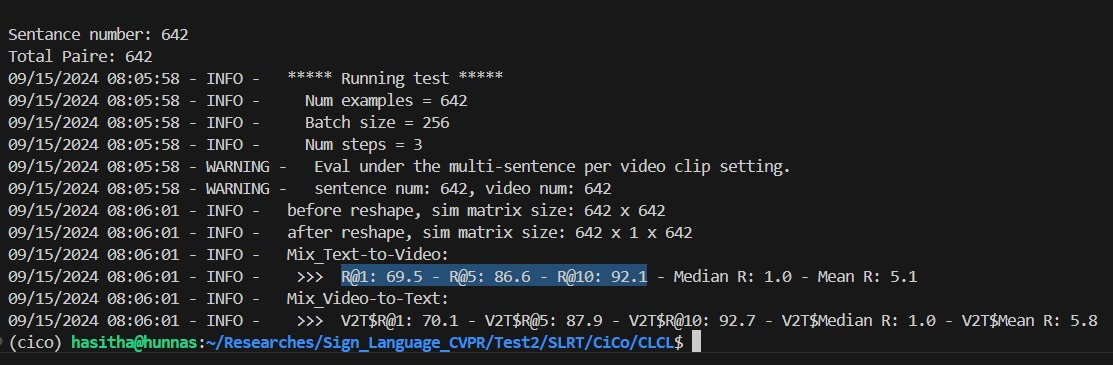

### 4. **Implementation Details**
- **Sliding Window Mechanism**: Used to handle long sign videos by splitting them into overlapping clips, which are processed individually to extract features.
- **Transformers**:
  - **Vision Transformer**: Processes sign video features to capture contextual information.
  - **Text Transformer**: Processes the text inputs.


> Just like CLIP but not exactly !

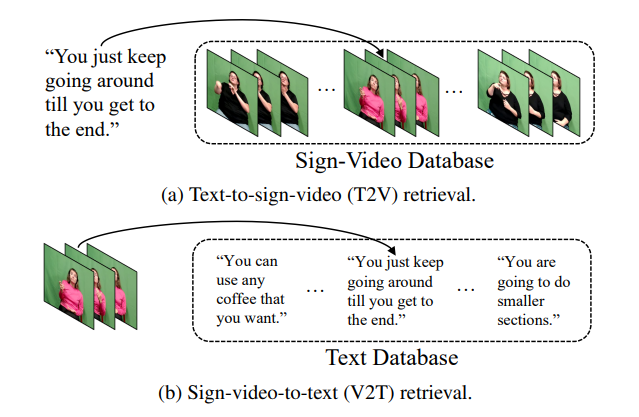

CLIP:

- **Vision Encoder**: CLIP processes images using a vision encoder (Usually It can be based on either a ResNet or a (ViT) Vision Transformer). It converts the raw pixel data into a fixed-size embedding representation.

- **Text Encoder**: The text encoder (A normal text transformer like BERT) processes textual descriptions (captions, prompts, or tags) and encodes them into a feature vector/embedding.



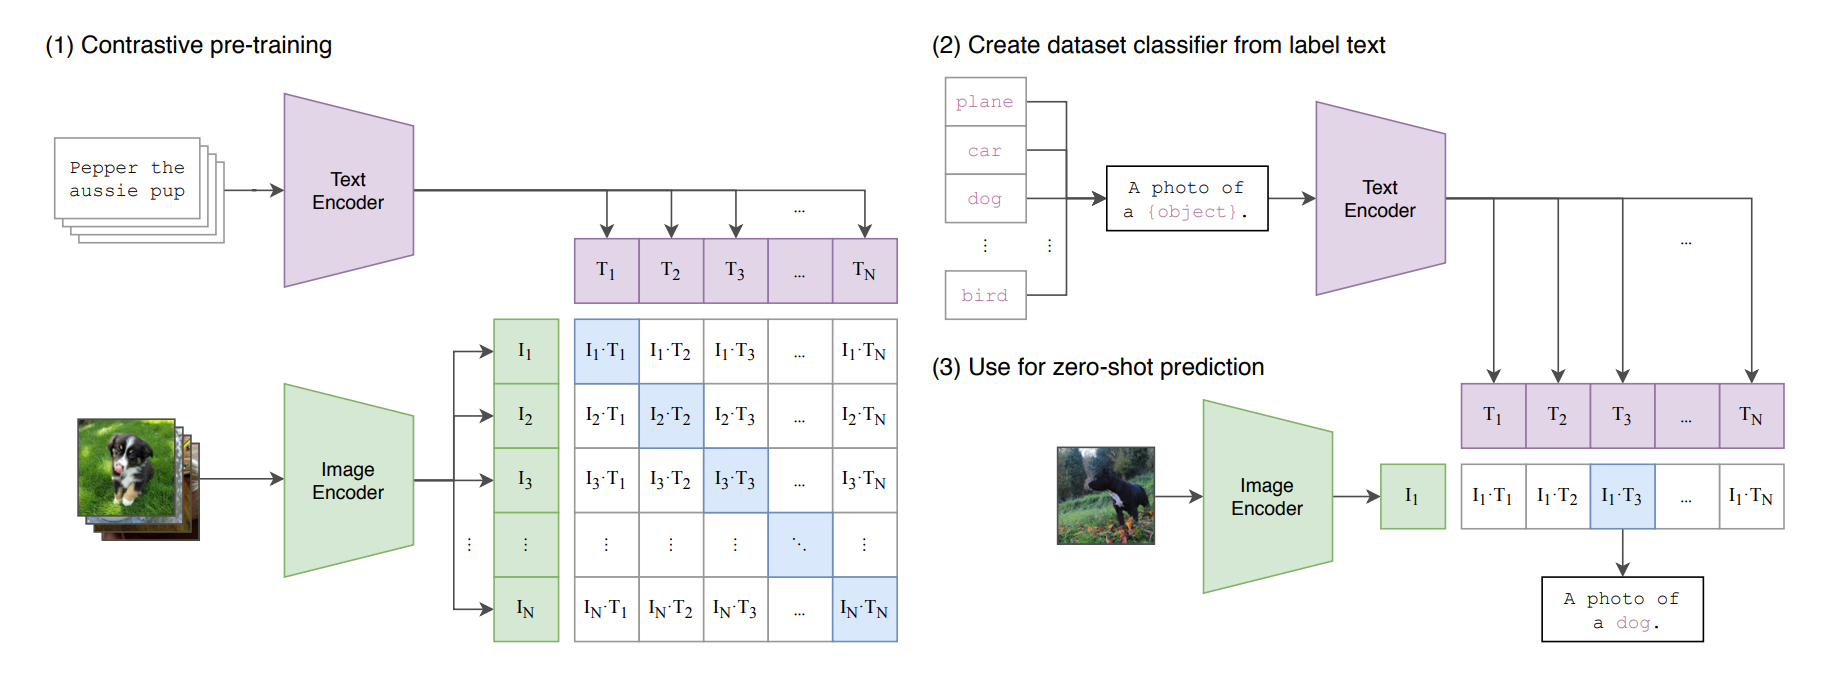

Here the training is to align visual and textual representations in a shared embedding space using contrastive learning:
  - **Image-to-Text Similarity $(s(V_i, T_i))$:**

    $$
    s(V_i, T_i) = g_V(I(x_i)) \cdot g_T(T(t_{y_i}))
    $$

    A dot product of their projected embeddings, where $I(x_i)$ is the image feature from the image encoder, $T(t_{y_i})$ is the text feature from the text encoder, and $g_V$ and $g_T$ are linear projection layers to map them into a shared embedding space.
  - **Image-to-Text Contrastive Loss $(L_{i2t})$** :

    $$
    L_{i2t}(i) = - \log \frac{\exp(s(V_i, T_i))}{\sum_{a=1}^B \exp(s(V_i, T_a))}
    $$

  - **Text-to-Image Contrastive Loss $(L_{t2i})$**:

    $$
    L_{t2i}(i) = - \log \frac{\exp(s(V_i, T_i))}{\sum_{a=1}^B \exp(s(V_a, T_i))}
    $$


 - **Combined Loss $(L)$**:

    The total loss for the model is the average of the image-to-text and text-to-image contrastive losses. This ensures that the model learns to align both modalities symmetrically.

    $$
    L = \frac{1}{2} \left( \sum_{i=1}^B L_{i2t}(i) + \sum_{i=1}^B L_{t2i}(i) \right)
    $$


 -  **Training Objective**:
    The goal of training is to minimize this combined loss, thereby encouraging the model to assign higher similarity scores to matched image-text pairs compared to unmatched pairs.


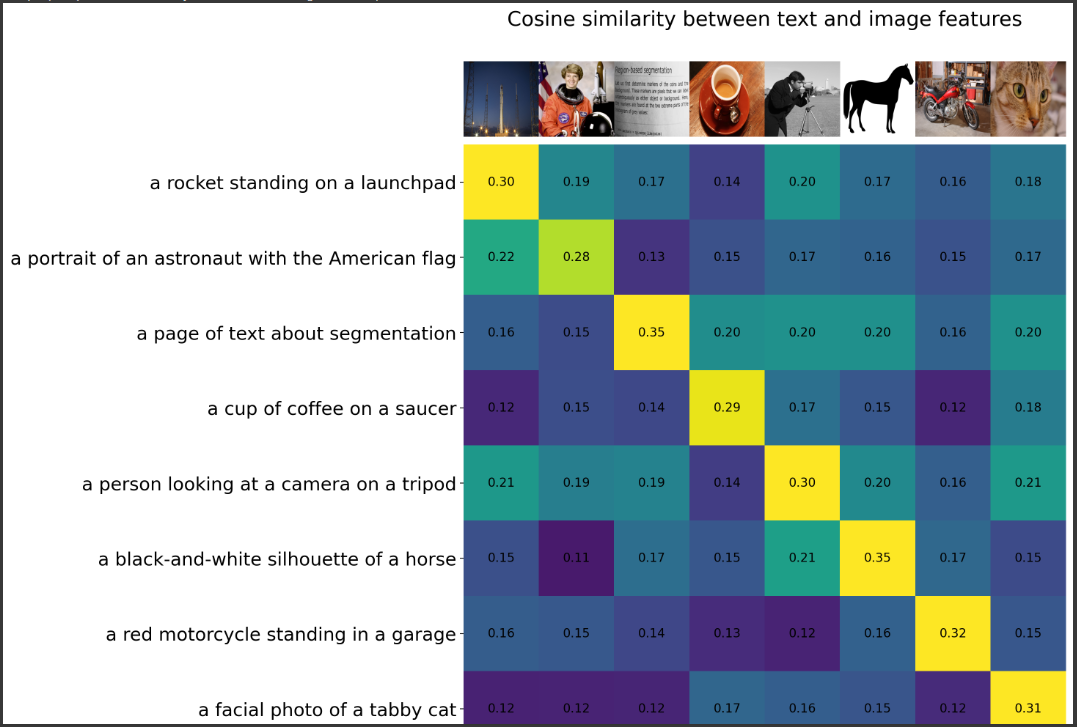

### 5. **Conclusion**
CiCo combines powerful domain-agnostic and domain-aware encoders with cross-lingual contrastive learning to outperform previous methods in sign language retrieval tasks. The modular architecture allows for efficient processing of long videos and effective learning of cross-modal alignments between sign languages and natural languages.

# 2.4 [CVPR 2023] Natural Language-Assisted Sign Language Recognition [Paper](https://arxiv.org/pdf/2303.12080) [Code](https://github.com/FangyunWei/SLRT)

### Introduction
The paper introduces the **Natural Language-Assisted Sign Language Recognition (NLA-SLR)** framework, designed to improve recognition of **visually indistinguishable signs (VISigns)** in sign language by incorporating semantic information from natural language glosses. It achieves this through two main techniques: **Language-aware Label Smoothing (Lang-LS)** and **Inter-modality Mixup**, alongside a **Video-Keypoint Network (VKNet)** for feature extraction.

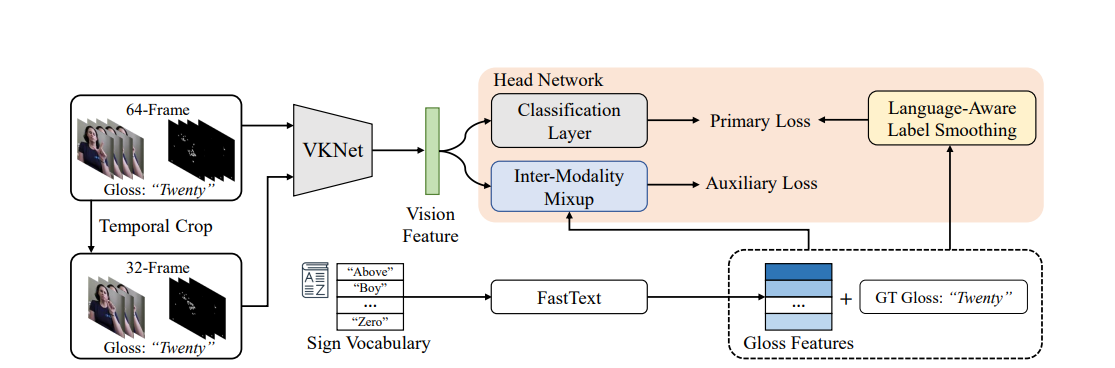

Figure shows an overview of NLA-SLR. Given a training video, it temporally crop a 64-frame clip and use HRNet trained on
COCO-WholeBody to estimate its keypoint sequence which is represented by a set of heatmaps, yielding a 64-frame video-keypoint
pair. Then It temporally crop a 32-frame counterpart and feed it along with the 64-frame pair into the proposed VKNet (Figure 4) to
extract the vision feature. The head network (Figure 5) has a two-branch architecture consisting of a language-aware label smoothing
branch and an inter-modality mixup branch. It only retain the VKNet and the classification layer in the head network for inference.

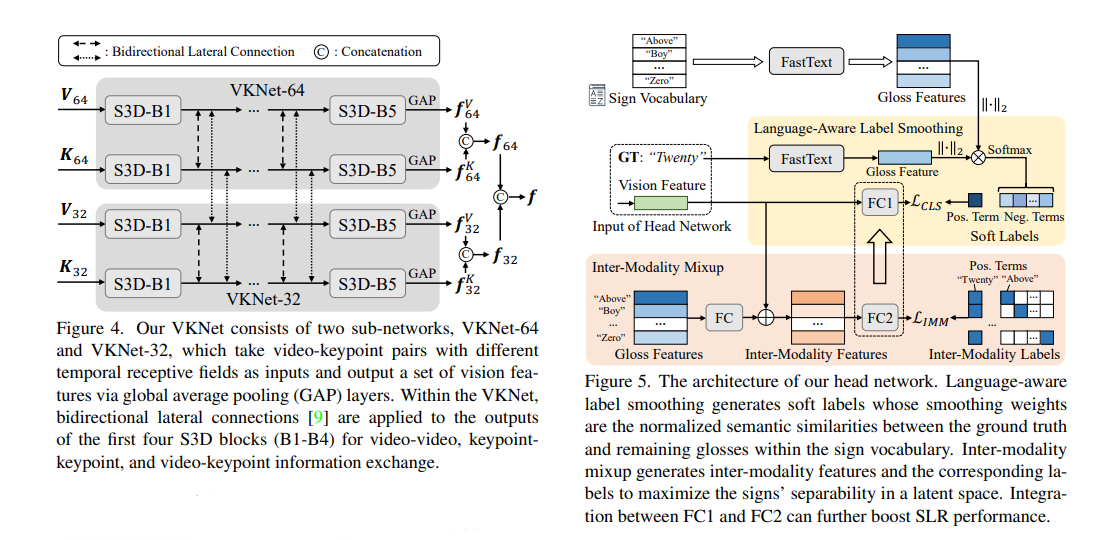



### Pseudo Code Summary
1. **Data Preprocessing:**
   - Extract RGB frames and body keypoints from sign videos.
2. **Feature Extraction (VKNet):**
   - Input: Video frames, Keypoint heatmaps
   - Output: Vision features via temporal cropping and pooling.
3. **Label Smoothing (Lang-LS):**
   - For each gloss, compute soft labels based on semantic similarity.
4. **Inter-Modality Mixup:**
   - Blend vision features with gloss features for robust classification.

### Equations and Explanation

1. **Language-aware Label Smoothing:**
   ```python
   for each training sample:
       gloss_feature = fastText(gloss)
       similarity_scores = cosine_similarity(gloss_feature, all_glosses)
       soft_label = (1 - ε) if gloss == true_label else ε * exp(similarity_scores[i]/τ)
   ```
   - **Equation:** $ y[i] = (1 - \epsilon) $ if $ i $ is true label, else $ \epsilon \cdot \frac{\exp(s[i]/\tau)}{\sum_j \exp(s[j]/\tau)} $
   - **Explanation:** Softens the label based on semantic similarity to reduce the impact of visual ambiguity in VISigns.

2. **Inter-Modality Mixup:**
   ```python
   for each gloss in vocabulary:
       blended_feature = vision_feature + gloss_feature
       pred = classify(blended_feature)
   ```
   - **Equation:** $ F = f_{\text{vision}} + E_{\text{gloss}} $
   - **Explanation:** Combines vision and language features to maximize separability in feature space, improving accuracy on visually similar but semantically distinct signs.

3. **Video-Keypoint Network (VKNet):**
   ```python
   for each video-keypoint pair:
       feature_64 = VKNet-64(video_frames, keypoints)
       feature_32 = VKNet-32(video_frames, keypoints)
       final_feature = concatenate(feature_64, feature_32)
   ```
   - **Explanation:** Uses RGB and keypoints from varying temporal frames to capture comprehensive visual details, enhancing robustness across different contexts.

## Results:

The proposed methods outperform state-of-the-art models in three benchmark datasets: MSASL, WLASL, and NMFs-CSL. The combination of language-aware label smoothing and inter-modality mixup significantly boosts the model’s accuracy, especially in cases where VISigns make classification challenging.

In summary, the paper introduces natural language processing techniques to enhance sign language recognition, handling both visually similar signs with shared meanings and visually similar signs with distinct meanings.

# 2.5 [ECCV 2024] A Simple Baseline for Spoken Language to Sign Language Translation with 3D Avatars [Paper](https://arxiv.org/pdf/2401.04730) [Code](https://github.com/FangyunWei/SLRT)

### Introduction
The paper introduces a new baseline for translating spoken languages to sign languages, called Spoken2Sign translation, using 3D avatars for enhanced visualization. Unlike previous methods that used 2D video or keypoint sequences, this approach leverages 3D avatars, which allow for more natural and understandable sign representation from multiple viewpoints. The system involves three stages: (1) building a gloss-video dictionary, (2) estimating 3D sign representations for each entry, and (3) performing Spoken2Sign translation through a Text2Gloss translator, a sign connector, and a rendering module.


Figure 1: Comparison of Traditional Methods and Proposed 3D Avatar Representation




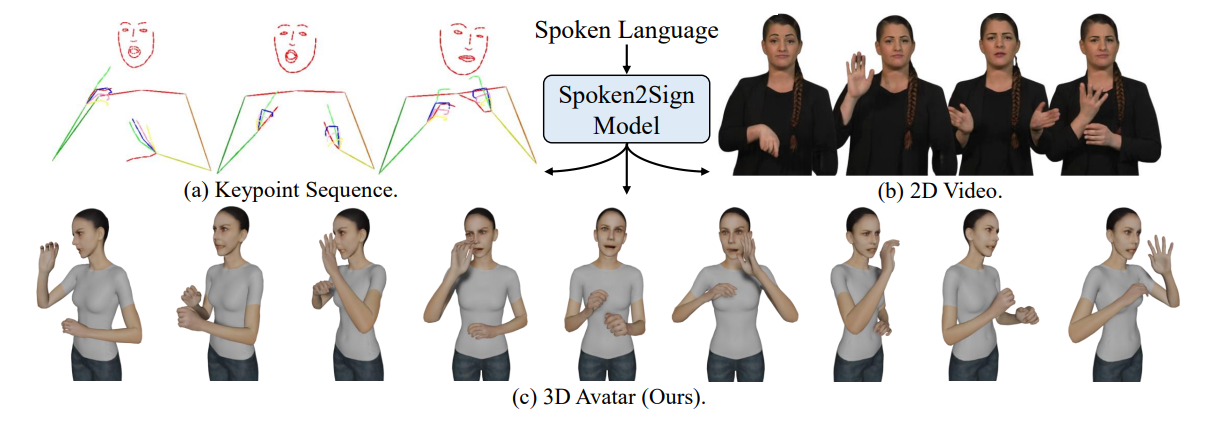

This figure contrasts previous Spoken2Sign approaches using keypoint sequences (Figure 1a) or 2D videos (Figure 1b) with the 3D avatar approach proposed in this work (Figure 1c). The 3D avatar provides flexibility for multi-view representations, improving the user experience.

### Pseudo Code for Each Stage

### Stage 1: Dictionary Construction
```python
# Inputs: continuous sign language video dataset
# Output: gloss-video dictionary

def build_gloss_video_dictionary():
    initialize dictionary = {}
    for video in dataset:
        gloss_sequence = TwoStream_SLR(video)
        for gloss in gloss_sequence:
            if gloss not in dictionary:
                dictionary[gloss] = []
            dictionary[gloss].append(video_segment_of(gloss))
    return dictionary
```
**Explanation:**
In this stage, a dictionary of gloss-video pairs is created. The TwoStream-SLR model is used to segment continuous sign language videos into isolated signs, producing a dictionary that maps each gloss to its corresponding video segments.

### Stage 2: 3D Sign Estimation
```python
# Inputs: gloss-video dictionary
# Output: gloss-3D sign dictionary

def estimate_3D_signs(gloss_video_dict):
    initialize gloss_3D_dict = {}
    for gloss, videos in gloss_video_dict.items():
        for video in videos:
            3D_representation = SMPLSign_X(video)
            gloss_3D_dict[gloss].append(3D_representation)
    return gloss_3D_dict
```
**Equation:**
The 3D sign estimation optimizes a loss function $ L $ defined as:
$$
L = L_{\text{joint}} + L_{\text{prior}} + L_{\text{penetration}} + \lambda_1 L_{\text{unseen}} + \lambda_2 L_{\text{upright}} + \lambda_3 L_{\text{smooth}}
$$
- $ L_{\text{joint}} $: Minimizes the difference between 2D projected keypoints and 3D model.
- $ L_{\text{prior}} $: Enforces prior knowledge about the signer's body.
- $ L_{\text{penetration}} $: Prevents self-collisions.
- $ L_{\text{unseen}}, L_{\text{upright}}, L_{\text{smooth}} $: Regularization terms for temporal consistency and unseen keypoints.


Figure 2: Overview of the Methodology

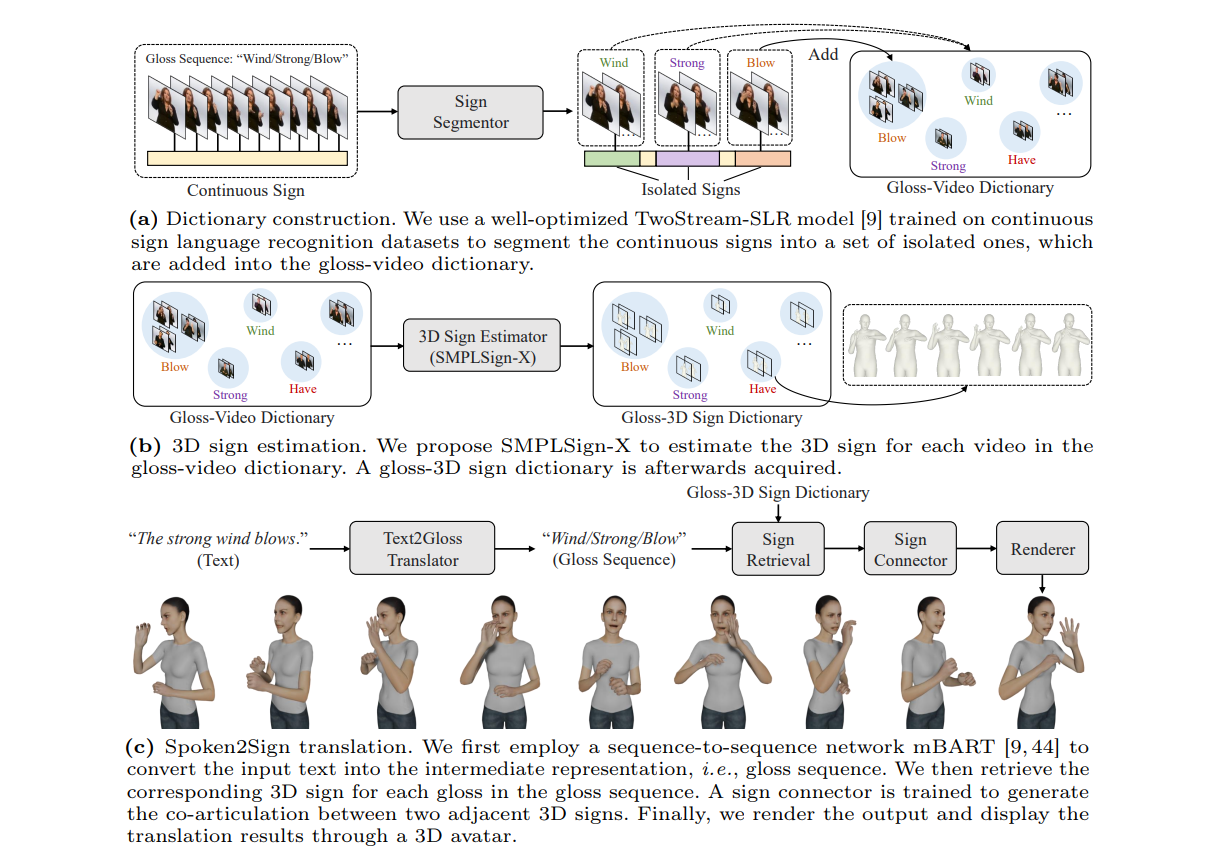


This figure provides a visual summary of the three stages: (a) construction of a gloss-video dictionary, (b) estimation of 3D signs using SMPLSign-X, and (c) Spoken2Sign translation. It illustrates how the translation is performed from spoken text to 3D signs displayed through an avatar.

### Stage 3: Spoken2Sign Translation
```python
# Inputs: spoken language text
# Output: 3D sign language sequence

def spoken2sign_translation(text):
    gloss_sequence = Text2Gloss(text)
    3D_sign_sequence = []
    for gloss in gloss_sequence:
        3D_sign = retrieve_best_sign_from(gloss_3D_dict, gloss)
        3D_sign_sequence.append(3D_sign)
    for i in range(len(3D_sign_sequence) - 1):
        coarticulation = sign_connector(3D_sign_sequence[i], 3D_sign_sequence[i+1])
        3D_sign_sequence.insert(2*i+1, coarticulation)
    render_sign_avatar(3D_sign_sequence)
```
**Equation:**
For co-articulation between signs, a learned sign connector is used to predict the duration $ L $:
$$
L = \text{MLP}(D_{\text{prev}}^{JSC}, D_{\text{next}}^{JSC}, D_{\text{prev}}^{JSC} - D_{\text{next}}^{JSC})
$$
where $ D_{\text{prev}}^{JSC} $ and $ D_{\text{next}}^{JSC} $ are the 3D keypoints of adjacent signs.

---

Figure 3: Illustration of the Sign Connector

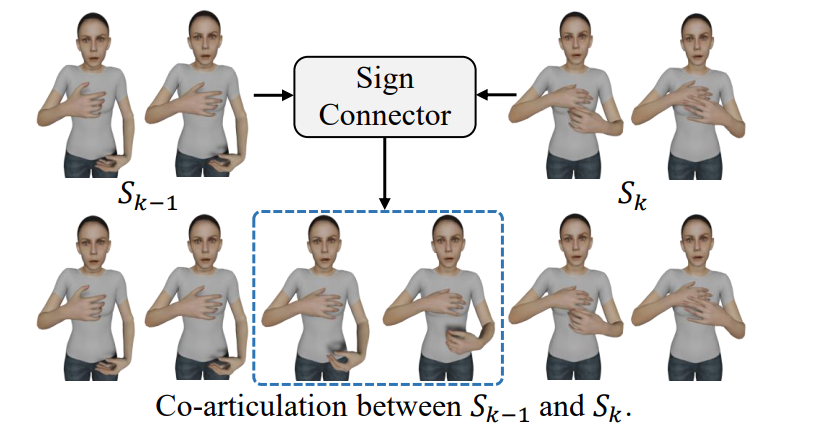


This figure depicts the sign connector's role in predicting co-articulation durations between two adjacent signs, providing smooth transitions between them in 3D space.

### Summary
The methodology involves creating a gloss-video dictionary, estimating 3D representations, and translating spoken language into sign language displayed by a 3D avatar. By employing equations for temporal consistency and accurate 3D fitting, the system offers an advanced solution for multi-view and augmented sign language translation.